In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [4]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [5]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [6]:
stats_name = "yeast_v5_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [10]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs, balance=True)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [11]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)

-0.018555202366876015
-0.017172535478982644
0.15949723926705456
0.01022554069958134
-0.03429450382046319
0.14697767745171808

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [12]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


In [ ]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx].item()).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 6), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [13]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [14]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [15]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [16]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [17]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [18]:
wd=1e-5

In [16]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  0.0%                                                
[1]: 0.05714%
[2]: 0.6286%
[3]: 0.5714%
[4]:  1.0%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      9.739349   2.728909   0.330159  
[0]:  0.0%                                                
[1]: 0.4286%
[2]: 0.2571%
[3]: 0.7429%
[4]: 0.9714%
[5]:  0.0%
    1      5.185446   2.0983     0.330159  
[0]:  0.0%                                                
[1]:  0.4%
[2]:  0.0%
[3]: 0.1143%
[4]: 0.8143%
[5]:  1.0%
    2      3.331183   1.744938   0.339683  
[0]:  0.0%                                                
[1]: 0.4286%
[2]: 0.6286%
[3]: 0.5429%
[4]: 0.9714%
[5]: 0.1429%
    3      2.423363   1.138372   0.365079  
[0]:  0.0%                                                
[1]: 0.1857%
[2]: 0.9143%
[3]: 0.2857%
[4]: 0.8714%
[5]:  0.0%
    4      2.462863   2.482789   0.419048  
[0]:  0.0%                                                
[1]: 0.3571%
[2]:  0.0%
[3]: 0.9714%
[4]: 0.4714%
[5]: 0.1143%
    5 

[array([0.93809]), 0.6476190460106683]

In [17]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_1')

[0]: 0.02857%                                              
[1]: 0.1857%
[2]: 0.7714%
[3]:  1.0%
[4]: 0.5286%
[5]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.43694    0.88204    0.660317  
[0]: 0.07143%                                              
[1]: 0.07143%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.5429%
[5]:  0.2%
    1      0.485031   0.995252   0.663492  
[0]: 0.05714%                                              
[1]: 0.3571%
[2]:  0.0%
[3]:  1.0%
[4]: 0.4286%
[5]: 0.7143%
    2      0.505524   1.170235   0.650794  
[0]: 0.04286%                                              
[1]: 0.1429%
[2]: 0.4286%
[3]: 0.9714%
[4]: 0.5714%
[5]: 0.1429%
    3      0.482043   1.216351   0.580952  
[0]: 0.02857%                                              
[1]: 0.2714%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.7857%
[5]: 0.2286%
    4      0.475988   1.090002   0.653968  
[0]: 0.04286%                                              
[1]: 0.08571%
[2]: 0.6571%
[3]:  1.0%
[4]:  0.7%
[5]: 0.1429%
 

[array([0.46524]), 0.857142858845847]

In [19]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_C_Resnet_per_class_3')

[0]: 0.1857%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]:  0.7%
[5]: 0.7714%
epoch      trn_loss   val_loss   accuracy   
    0      0.1267     0.421499   0.844444  
[0]: 0.1857%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.6714%
[5]: 0.7714%
    1      0.125395   0.395248   0.853968  
[0]: 0.1571%                                               
[1]: 0.3143%
[2]: 0.3714%
[3]:  1.0%
[4]: 0.7429%
[5]: 0.7714%
    2      0.12648    0.346227   0.866667  
[0]: 0.1714%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.7143%
[5]: 0.8571%
    3      0.127998   0.342675   0.879365  
[0]: 0.1571%                                               
[1]:  0.3%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8571%
    4      0.126569   0.341496   0.869841  
[0]: 0.1571%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]:  0.7%
[5]: 0.8857%
   

[0]: 0.1714%                                               
[1]: 0.3429%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8286%
    98     0.102074   0.323798   0.873016  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.2286%
[3]: 0.9714%
[4]: 0.7286%
[5]: 0.8571%
    99     0.099644   0.320497   0.873016  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.7429%
[5]: 0.8286%
   100     0.098191   0.31051    0.88254   
[0]: 0.1714%                                               
[1]: 0.3286%
[2]:  0.2%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.9143%
   101     0.103095   0.364226   0.873016  
[0]: 0.1714%                                                
[1]: 0.3143%
[2]: 0.2857%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8286%
   102     0.097602   0.341312   0.863492  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.3714%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.8286%
   103     0.095864   0.374177   0.860

[0]: 0.1857%                                                
[1]: 0.3143%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.8286%
   147     0.096628   0.368414   0.853968  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]: 0.2571%
[3]: 0.9714%
[4]: 0.7143%
[5]: 0.8571%
   148     0.091768   0.32927    0.879365  
[0]: 0.1857%                                                
[1]: 0.3143%
[2]: 0.2286%
[3]: 0.9714%
[4]: 0.7571%
[5]: 0.8571%
   149     0.088262   0.336212   0.860317  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]: 0.1429%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.9143%
   150     0.090358   0.357641   0.860317  
[0]: 0.1714%                                                
[1]: 0.3143%
[2]: 0.2286%
[3]:  1.0%
[4]: 0.7857%
[5]: 0.8286%
   151     0.090551   0.338561   0.857143  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]:  0.2%
[3]: 0.9714%
[4]: 0.7429%
[5]: 0.8571%
   152     0.089507   0.329528  

[array([0.30867]), 0.8761904799748981]

In [21]:
learn.load('Objective_C_Resnet_per_class_3')

In [22]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_C_Resnet_per_class_balanced_1')

[0]:  0.2%                                                 
[1]: 0.3429%
[2]: 0.3143%
[3]: 0.9714%
[4]:  0.6%
[5]: 0.8571%
epoch      trn_loss   val_loss   accuracy   
    0      0.15561    0.369281   0.850794  
[0]: 0.2143%                                               
[1]: 0.3571%
[2]: 0.4286%
[3]: 0.9714%
[4]: 0.6143%
[5]: 0.8286%
    1      0.141295   0.442286   0.793651  
[0]:  0.2%                                                 
[1]: 0.3714%
[2]: 0.4286%
[3]: 0.9429%
[4]: 0.5571%
[5]: 0.8286%
    2      0.133995   0.427526   0.825397  
[0]: 0.1714%                                               
[1]: 0.3571%
[2]: 0.2571%
[3]: 0.9429%
[4]: 0.6286%
[5]: 0.9143%
    3      0.136289   0.389124   0.819048  
[0]: 0.1857%                                               
[1]: 0.3429%
[2]: 0.4286%
[3]: 0.9143%
[4]:  0.6%
[5]: 0.8286%
    4      0.13424    0.433875   0.806349  
[0]: 0.1857%                                               
[1]: 0.3571%
[2]: 0.4286%
[3]: 0.9429%
[4]:  0.7%
[5]:

    48     0.092919   0.421958   0.825397  
[0]: 0.1571%                                                
[1]: 0.2714%
[2]: 0.4286%
[3]: 0.9714%
[4]: 0.6857%
[5]: 0.8286%
    49     0.088819   0.394555   0.834921  
[0]: 0.1571%                                                
[1]: 0.2714%
[2]: 0.3429%
[3]: 0.9429%
[4]: 0.6571%
[5]: 0.9143%
    50     0.0912     0.396516   0.838095  
[0]: 0.1571%                                                
[1]: 0.3143%
[2]: 0.4571%
[3]: 0.9429%
[4]:  0.7%
[5]: 0.7714%
    51     0.090661   0.29526    0.87619   
[0]: 0.1571%                                                
[1]: 0.2714%
[2]:  0.4%
[3]: 0.8571%
[4]: 0.6571%
[5]: 0.8286%
    52     0.102501   0.400367   0.834921  
[0]: 0.1571%                                                
[1]: 0.2857%
[2]: 0.4286%
[3]: 0.8857%
[4]: 0.6429%
[5]:  0.8%
    53     0.096995   0.412672   0.825397  
[0]: 0.1571%                                                
[1]: 0.2714%
[2]: 0.4286%
[3]: 0.8571%
[4]:  0.7%
[

[array([0.41989]), 0.8253968308842371]

In [21]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

[0]: 0.1857%                                                
[1]: 0.3286%
[2]: 0.1429%
[3]:  1.0%
[4]: 0.7429%
[5]: 0.9429%
epoch      trn_loss   val_loss   accuracy   
    0      0.102972   0.337027   0.873016  

CPU times: user 13.8 s, sys: 5.42 s, total: 19.2 s
Wall time: 13 s


[array([0.33703]), 0.8730158680961245]

In [24]:
log_preds

array([[-0.00003, -0.0453 , -0.0577 , -0.     , -0.29234, -0.10248, -0.09074, -0.01947, -0.00217, -0.00001],
       [-0.00014, -0.11584, -0.06732,  0.     , -0.41966, -0.21919, -0.73857, -0.0374 , -0.00811, -0.00003],
       [-0.00006, -0.02095, -0.12846, -0.     , -0.35818, -0.23698, -0.18994, -0.01822, -0.02132, -0.00001],
       [-0.00001, -0.00779, -0.11035, -0.     , -0.48496, -0.44001, -0.04328, -0.01898, -0.00553, -0.00001],
       [-0.0002 , -0.03107, -0.06205,  0.     , -0.45828, -0.16663, -0.595  , -0.04638, -0.00774, -0.00008]],
      dtype=float32)

[[70  0  0  0  0  0]                         
 [22 45  0  0  3  0]
 [ 0  0 32  2  0  1]
 [ 0  0  0 35  0  0]
 [15  3  0  0 52  0]
 [ 0  0  9  1  0 25]]


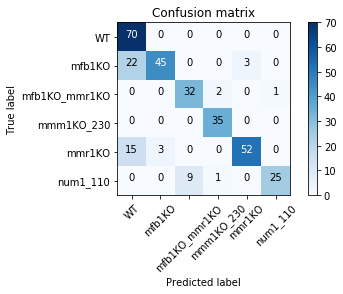

In [23]:
# analyze results 
log_preds, y = learn.TTA(n_aug=1)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
# cm = confusion_matrix(preds,y)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)